In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
from PIL import Image

%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../')
sys.path.append('../core')

from raft import RAFT
# from train_bbnet import get_args, load_model
from train import get_args, load_model
import datasets as raft_datasets
import utils.flow_viz as flow_viz

def set_args(args_dict={}):
    args = get_args("")
    for k,v in args_dict.items():
        args.__setattr__(k, v)
    return args

def tensor_to_arr(tensor, ex=0):
    if len(tensor.shape) == 4:
        tensor = tensor[ex]
    return tensor.detach().permute(1, 2, 0).cpu().numpy()

def viz(tensor, ex=0):
    im = tensor_to_arr(tensor, ex)
    if im.max() > 2.0:
        im = im / 255.0
    plt.imshow(im)
    
def zscore(x, eps=1e-6):
    m = x.mean((-2,-1), True)
    s = x.std((-2,-1), True)
    return (x - m) / s.clamp(min=eps)

def get_patches(im, radius=1):
    if radius == 0:
        return im
    shape = im.shape
    if len(shape) == 5:
        im = im.view(shape[0]*shape[1], *shape[2:])
    B,C,H,W = im.shape
    
    im = F.pad(im, (radius, radius, radius, radius))
    k = 2*radius+1
    im = F.unfold(im, (k, k)).view(-1,C*(k**2),H,W)
    if len(shape) == 5:
        im = im.view(shape[0], shape[1], *im.shape[1:])
    return im    
    
def vis_local_affinities(affinities, node=[250,400]):
    aff_node = affinities[:,:,node[0],node[1]]

    A = torch.zeros_like(affinities)
    A[:,:,node[0],node[1]] = aff_node
    K = (aff_node.shape[-1] - 1) // 2
#     aff_node = torch.cat([A[:,:K], torch.zeros_like(A[:,:1]), A[:,K:]], 1)    
    aff_node = torch.cat([A[:,:K], torch.zeros_like(A[:,:1]), A[:,(K+1):]], 1)        
    effects = fprop.compute_local_effects(torch.ones_like(affinities[:,:1]), aff_node)
    return effects

def viz_raft_prediction(model, dataset, ex=0, iters=[1,12,24], thingness=False, 
                        centroid=False, thresh=None, time_it=False, is_test=False, sigmoid=True):
    dataset.is_test = is_test
    dataset.get_backward_frame = False
    if ex is None:
        ex = np.random.randint(0, len(dataset))
    try:
        img1, img2, gt, _ = dataset[ex]
    except:
        img1, img2 = dataset[ex][:2]
        gt = None
    dataset.get_backward_frame = True
    preds = []
    if not isinstance(iters, list):
        iters = [iters]
    for it in iters:
        s = time.time()
        _, pred = model(img1[None].cuda(), img2[None].cuda(), iters=it, test_mode=True)
        e = time.time()
        if time_it:
            print("%0.3f seconds for %d iters" % (e - s, it)) 
        if thingness:
            pred = (nn.Sigmoid() if sigmoid else nn.Identity())(pred)[0,0].detach().cpu().numpy()
            if thresh is not None:
                pred = (pred > thresh)
        elif centroid:
            pass
        else:
            if thresh is None:
                pred = flow_viz.flow_to_image(tensor_to_arr(pred))
            else:
                pred = pred.square().sum(-3, True).sqrt()[0,0].detach().cpu().numpy()
                pred = (pred > thresh)
        preds.append(pred)
    if gt is not None:
        _flow_gt = flow_viz.flow_to_image(tensor_to_arr(gt))

    fig, axes = plt.subplots(
        1,1 + len(iters) + int(gt is not None), figsize=(4 + 4*int(gt is not None) + 4*len(iters),4))
    axes[0].imshow(img1.permute(1, 2, 0).numpy() / 255.)
    for i in range(len(iters)):
        axes[1+i].imshow(preds[i])
    if gt is not None:
        axes[-1].imshow(_flow_gt)
    
    titles = ['img1'] + ['pred @ %d iters' % it for it in iters] + (['gt'] if gt is not None else [])
    
    for i, ax in enumerate(axes):
        ax.set_title(titles[i], fontsize=18)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout()
    plt.show()  
    

def viz_boundary_preds(b_preds, thresh=0.1, max_speed=0.1, do_plot=True):
    motion = None
    if b_preds.shape[1] == 9:
        c1_preds, b_preds, c2_preds = b_preds.split([4,1,4], dim=-3)
        c_preds = torch.cat([c1_preds, c2_preds], -3).softmax(-3)
        c_preds_rgb = fprop.circular_target_to_spatial_moment(c_preds)
    elif b_preds.shape[1] == 3:
        b_preds, c_preds = b_preds.split([1,2], dim=-3)
        c_preds_rgb = c_preds
    elif b_preds.shape[1] == 4:
        motion, b_preds, c_preds = b_preds.split([1,1,2], dim=-3)
        c_preds_rgb = c_preds
    b_preds = b_preds.sigmoid()
    if do_plot:
        vis_utils.imshow(data_utils.FlowToRgb(max_speed=max_speed)(c_preds_rgb) * (b_preds > thresh).float())    
    return (b_preds, c_preds, motion)


def get_boundary_preds(model, dataset, ex, static_input=True, backward=False, iters=12):
    img1, img2 = [x[None].cuda() for x in dataset[ex][:2]]
    if backward:
        ups_mask, b_preds = model(img2, img2 if static_input else img1, test_mode=True, iters=iters)
    else:
        ups_mask, b_preds = model(img1, img1 if static_input else img2, test_mode=True, iters=iters)
    return (b_preds, ups_mask)

def get_motion_preds(model, dataset, ex, backward=False, iters=12):
    img1, img2 = [x[None].cuda() for x in dataset[ex][:2]]    
    if backward:
        ups_mask, m_preds = model(img2, img2, test_mode=True, iters=iters)
    else:
        ups_mask, m_preds = model(img1, img2, test_mode=True, iters=iters)
    return (m_preds, ups_mask)

def get_boundary_movie(model, dataset, ex, iters=12, thresh=None):
    img1, img2, img0 = [x[None].cuda() for x in dataset[ex][:3]]
    b1 = model(img1, img1, test_mode=True, iters=12)[-1]
    b2 = model(img2, img2, test_mode=True, iters=12)[-1]
    b0 = model(img0, img0, test_mode=True, iters=12)[-1]
    b_movie = []
    for b in [b0, b1, b2]:
        b_preds, c_preds = viz_boundary_preds(b, do_plot=False)
        if thresh is not None:
            b_movie.append((b_preds > thresh).float() * c_preds)
        else:
            b_movie.append(b_preds * c_preds)
    return torch.stack(b_movie, 1)

def get_video(dataset, ex=0, stride=1):
    dataset.get_backward_frame = True
    data = dataset[ex]
    video = torch.stack([x.cuda() for x in [data[2], data[0], data[1]]], 0) / 255.
    size = list(video.shape[-2:])
    if stride > 1:
        video = transforms.Resize((size[0] // stride, size[1] // stride))(video)
    return video[None]


/home/dbear/tenv/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:696: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  collections.MutableMapping.register(ParseResults)
/home/dbear/tenv/lib/python3.7/site-packages/pkg_resources/_vendor/pyparsing.py:2273: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  elif isinstance( exprs, collections.Sequence ):


In [4]:
def get_gt_motion_and_boundaries(dataset, ex, max_objects=8, radius=3):
    dataset.get_backward_frame = False
    dataset.get_gt_segments = True
    dataset.get_gt_flow = True    
    
    img1, img2, flow, segments = [x[None].cuda() for x in dataset[ex]]
    motion = (flow.abs().sum(1, True) > 0).float()
    obj_ids = torch.unique(segments)[:max_objects]
    masks = (segments == obj_ids.view(1, -1, 1, 1)).float()
    borders, _ = fprop.get_mask_boundaries(masks)
    masks, borders = masks[:,1:], borders[:,1:]
    size = masks.shape[-2:]
    orients = fprop.estimate_boundary_orientations(
        borders.view(-1, 1, *size),
        masks.view(-1, 1, *size),
        radius=radius,
        to_circle=False
    ).view(1, -1, 2, *size)
    return (img1, flow, motion, masks, borders, orients)

def mask_orientations(masks, boundaries, orientations):
    return (orientations * boundaries[:,:,None] * masks[:,:,None]).sum(1)

def get_adj_gt(masks, radius=3):
    masks = torch.cat([1-masks.amax(1, True), masks], -3)
    segments = masks.argmax(1, True)
    adj_gt = fprop.get_local_neighbors(
        segments, radius=radius, to_image=True, invalid=-1
    )[:,0] == segments
    return adj_gt.float()

def estimate_kp_adj(motion, boundaries, radius=3):
    r = radius
    k = 2*r + 1
    K = k**2
    null_idx = (K - 1) // 2
    B,_,H,W = motion.shape
    adj = F.one_hot(torch.tensor(null_idx), num_classes=K).to(motion.device)
    adj = adj.view(1,1,k,k).repeat(B*H*W, 1, 1, 1)
    mask = fprop.get_local_neighbors(motion, radius=r, invalid=0, to_image=True)[:,0]
    mask = mask.permute(0,2,3,1).reshape(B*H*W,1,k,k)
    adj = adj * mask
    boundaries = fprop.get_local_neighbors(boundaries, radius=r, invalid=0, to_image=True)[:,0]
    b = boundaries.permute(0,2,3,1).reshape(B*H*W,1,k,k)
    
#     u = 1 - adj
    kernel = torch.ones((3,3)).float().view(1,9,1,1).repeat(1,1,k,k).to(b.device)
    
    for it in range(r):
        adj_new = fprop.compute_local_effects(adj, kernel)
#         u = F.relu(u - fprop.compute_local_effects(adj.abs(), kernel))
        adj_new = adj_new * (1 - b) - adj_new.abs() * b
        adj = (adj + adj_new).clamp(min=-1, max=1) * mask        
    adj = F.relu(adj)
    adj = adj.view(B,H*W,K).permute(0,2,1).view(B,K,H,W)
    adj = torch.maximum(adj, boundaries) * motion
    return adj



# ex = 21
# _img, _flow, _motion, _masks, _borders, _orients = get_gt_motion_and_boundaries(tdw_dataset, ex)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
import dorsalventral.models.targets as targets
import dorsalventral.vis_utils as vis_utils
import dorsalventral.data.utils as data_utils
import dorsalventral.models.fire_propagation as fprop
import dorsalventral.models.layer_utils as layer_utils
import dorsalventral.models.segmentation.competition as competition
import dorsalventral.models.losses as losses
import kornia

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
tdw_dataset = raft_datasets.TdwFlowDataset(
#     root='/data5/dbear/tdw_datasets/playroom_large_v3copy/',
    root='/mnt/fs5/dbear/tdw_datasets/playroom_large_v3/',
#     dataset_names=['model_split_4'],    
    dataset_names=['model_split_%d' % split for split in range(5)],
    split='validation',
    filepattern="*",
#     test_filepattern="0*[0-4]",
    test_filepattern="*9",
    min_start_frame=5,
    max_start_frame=5,
    scale_to_pixels=True,
    get_gt_flow=True,
    get_backward_frame=True
)
print(len(tdw_dataset))
print(tdw_dataset.is_test)

625
True


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Load motion/boundary combined bootnet and viz predictions

In [311]:
# boundary_paths = !ls ../checkpoints/[0-9]*boundaryMotionComb*rnd0*large*
# boundary_paths = !ls ../checkpoints/[0-9]*boundaryStaticReg*rnd1*dtarg*fullplay*pretrained*

# boundary_paths = !ls ../checkpoints/[0-9]*boundaryStaticReg*rnd0*cthr075*fullplay*
# boundary_paths = !ls ../checkpoints/[0-9]*boundaryStaticReg*rnd0*small*nthr0*cthr075*fullplay*
boundary_paths = !ls ../checkpoints/[0-9]*boundaryStaticReg*rnd0*large*nthr0*fullplay*
# boundary_paths = !ls ../checkpoints/[0-9]*boundaryMotionReg*rnd0*large*nthr0*fullplay*


boundary_paths = sorted(boundary_paths, key=lambda s: int(s.split('/')[-1].split('_')[0]))
# !ls ../checkpoints/*motion*imtarg*thr0*
for i,p in enumerate(boundary_paths):
    print(i, p)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0 ../checkpoints/5000_boundaryStaticReg-rnd0-tdw-bs4-large-dtarg-nthr0-cthr075-pr1-tds2-fullplayall.pth
1 ../checkpoints/10000_boundaryStaticReg-rnd0-tdw-bs4-large-dtarg-nthr0-cthr075-pr1-tds2-fullplayall.pth
2 ../checkpoints/15000_boundaryStaticReg-rnd0-tdw-bs4-large-dtarg-nthr0-cthr075-pr1-tds2-fullplayall.pth
3 ../checkpoints/20000_boundaryStaticReg-rnd0-tdw-bs4-large-dtarg-nthr0-cthr075-pr1-tds2-fullplayall.pth
4 ../checkpoints/25000_boundaryStaticReg-rnd0-tdw-bs4-large-dtarg-nthr0-cthr075-pr1-tds2-fullplayall.pth
5 ../checkpoints/30000_boundaryStaticReg-rnd0-tdw-bs4-large-dtarg-nthr0-cthr075-pr1-tds2-fullplayall.pth
6 ../checkpoints/35000_boundaryStaticReg-rnd0-tdw-bs4-large-dtarg-nthr0-cthr075-pr1-tds2-fullplayall.pth
7 ../checkpoints/40000_boundaryStaticReg-rnd0-tdw-bs4-large-dtarg-nthr0-cthr075-pr1-tds2-fullplayall.pth


In [312]:
b_idx = 7
boundary_path = boundary_paths[b_idx]
print(boundary_path)

b_net = load_model(
    boundary_path,
    small=False,
    static_input=False,
    orientation_type='regression',
    cuda=True, 
    train=False)
b_net.module.freeze_bn()
b_net.eval()
print(layer_utils.num_parameters(b_net))

../checkpoints/40000_boundaryStaticReg-rnd0-tdw-bs4-large-dtarg-nthr0-cthr075-pr1-tds2-fullplayall.pth
<All keys matched successfully> BoundaryClassifier
5559619


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


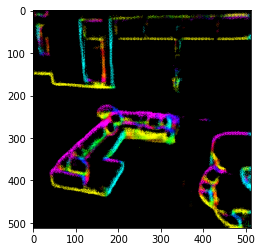

In [313]:
ex = 0
tdw_dataset.is_test = True
b, c = viz_boundary_preds(get_boundary_preds(b_net, tdw_dataset, ex, iters=12, static_input=False)[0])[:2]


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


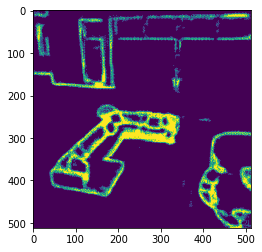

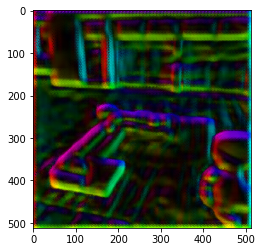

In [314]:
vis_utils.imshow(b > 0.1)
vis_utils.imshow(data_utils.FlowToRgb(0.5)(c))

In [297]:
motion_paths = !ls ../checkpoints/[0-9]*motion*dtarg*fullplay*ctd*
# motion_paths = !ls ../checkpoints/[0-9]*motion*dtarg*pretrained*


motion_paths = sorted(motion_paths, key=lambda s: int(s.split('/')[-1].split('_')[0]))
# !ls ../checkpoints/*motion*imtarg*thr0*
for i,p in enumerate(motion_paths):
    print(i, p)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0 ../checkpoints/5000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr025-pr1-tds2-fullplayall-ctd.pth
1 ../checkpoints/10000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr025-pr1-tds2-fullplayall-ctd.pth
2 ../checkpoints/15000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr025-pr1-tds2-fullplayall-ctd.pth


In [333]:
m_idx = 2
motion_path = motion_paths[m_idx]

m_net = load_model(
    motion_path,
    small=False,
    cuda=True, 
    train=False)
print(motion_path)
m_net.module.freeze_bn()
m_net.eval()
print(layer_utils.num_parameters(m_net))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<All keys matched successfully> MotionClassifier
../checkpoints/15000_motion-rnd0-tdw-bs4-large-dtarg-nthr0-cthr025-pr1-tds2-fullplayall-ctd.pth
5555009


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


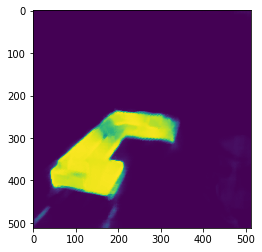

In [299]:
# ex = 2
# tdw_dataset.is_test = True
m_preds, _ = get_motion_preds(m_net, tdw_dataset, ex)
vis_utils.imshow(m_preds.sigmoid())

In [329]:
import copy
diff_params = copy.deepcopy(fprop.MotionSegmentTarget.DEFAULT_DIFF_PARAMS)
fp_params = copy.deepcopy(fprop.MotionSegmentTarget.DEFAULT_FP_PARAMS)
kp_params = copy.deepcopy(fprop.MotionSegmentTarget.DEFAULT_KP_PARAMS)
comp_params = copy.deepcopy(fprop.MotionSegmentTarget.DEFAULT_COMP_PARAMS)

## param updates
# diff_params.update({
#     'num_iters': 1000,
#     'noise_thresh': 0.5,
#     'confidence_thresh': 0.75
# })
diff_params = None
fp_params.update({
    'radius': 5,
    'num_sample_points': None,
    'resolution': 4,
    'motion_thresh': 0.5,
    'boundary_thresh': 0.05
})
kp_params.update({
    'num_iters': 200,
    'project': False
})
comp_params.update({
    'compete_thresh': 0.2,
    'num_competition_rounds': 2
})

MSTarget = fprop.MotionSegmentTarget(
    downsample_factor=4,
    adj_from_motion=True,
    diffusion_params=diff_params,
    fp_params=fp_params,
    kp_params=kp_params,
    competition_params=comp_params
).cuda()

FP = fprop.FirePropagation(compute_kp_args=False, **fp_params).cuda()

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [330]:
import time
t1 = time.time()
# ms = [0,2]
# m_bounds, _ = fprop.get_mask_boundaries(motion.sigmoid() > 0.5)
# c_est = fprop.estimate_boundary_orientations(m_bounds, motion.sigmoid(), radius=5)
stride = 1
ds = lambda x: F.avg_pool2d(x, stride, stride=stride)

_motion = ds(m_preds.sigmoid())
video = get_video(tdw_dataset, ex, stride=stride)
target, plateau, mask, boundaries, orientations = MSTarget(
    video=None,
    motion=_motion,
    boundaries=b,
    orientations=c,
#     boundaries=m_bounds,
#     orientations=c_est * m_bounds,
#     adj=None
)

# fire = FP(
#     motion=motion.sigmoid(),
# #     boundaries=m_bounds,
# #     orientations=c * (b > 0.5).float(),
#     boundaries=b,
#     orientations=c
# )
t2 = time.time()
print(t2 - t1)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1.0078330039978027


/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


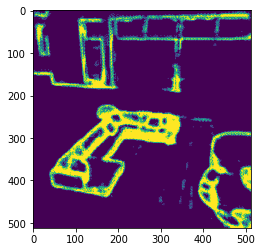

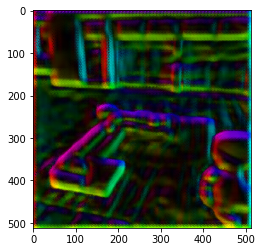

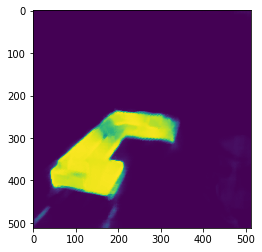

In [331]:
vis_utils.imshow(boundaries > 0.05)
vis_utils.imshow(data_utils.FlowToRgb(0.5)(orientations))
vis_utils.imshow(mask)
# vis_utils.imshow(fire)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


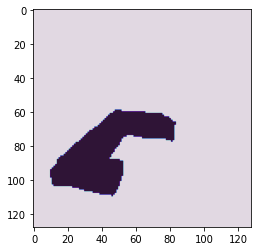

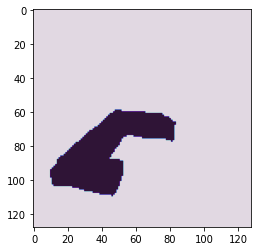

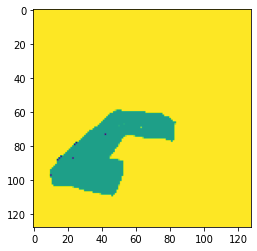

In [332]:
vis_utils.imshow(target[:,None], cmap='twilight', vmin=-1, vmax=target.amax()+1)
vis_utils.imshow(target[:,None], cmap='twilight', vmin=-1, vmax=target.amax()+1)

vis_utils.imshow(plateau.argmax(-1)[:,None])

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


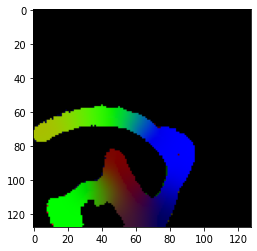

In [276]:
vis_utils.imshow(plateau.permute(0,3,1,2)[:,8:11])

# Look at targets on MOVi

In [320]:
data_dir = '/mnt/fs6/honglinc/dataset/tensorflow_datasets/movi_e/256x256/1.0.0'
movi_dataset = raft_datasets.MoviFlowDataset(
    root=data_dir,
    split='train',
    sequence_length=3
)

movi_loader = iter(torch.utils.data.DataLoader(movi_dataset, batch_size=1, shuffle=False))

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [321]:
data = movi_loader.next()
for v in data:
    print(v.shape, v.dtype)

/home/dbear/tenv/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


torch.Size([1, 3, 256, 256]) torch.float32
torch.Size([1, 3, 256, 256]) torch.float32
torch.Size([1, 3, 256, 256]) torch.float32
torch.Size([1, 1, 256, 256]) torch.uint8
